In [5]:
import pandas as pd
import numpy as np

与えられたデータを使い、タイタニックの生存者を予測する。  
[Kaggle](https://www.kaggle.com/c/titanic/data)

# 事前準備
データの基本量や、欠損などを確認する。

In [6]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")

#  データの内容を確認
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


trainの内容を学習し、testを喰わせ、生存情報を予測する。

In [8]:
# データのカラム数とサンプル数を確認
print("trainサンプル数: ", train.shape[0])
print("trainカラム数: ", train.shape[1])
print("testサンプル数: ", test.shape[0])
print("testカラム数: ", test.shape[1])

trainサンプル数:  891
trainカラム数:  12
testサンプル数:  418
testカラム数:  11


In [9]:
# 統計基本量の確認
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [10]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [11]:
# データ欠損の確認
def kesson(df):
    # nullの個数
    null_sum = df.isnull().sum()
    # nullの割合
    null_rate = null_sum / len(df) *100
    # 上記を横方向に連結
    table = pd.concat([null_sum, null_rate], axis=1)
    # ヘッダを修正
    table_ = table.rename(columns = {0: '欠損数', 1: '欠損率'})
    return table_

kesson(train)

,欠損数,欠損率
PassengerId,0,0.000000
Survived,0,0.000000
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
Age,177,19.865320
SibSp,0,0.000000
Parch,0,0.000000
Ticket,0,0.000000
Fare,0,0.000000


In [12]:
kesson(test)

,欠損数,欠損率
PassengerId,0,0.000000
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
Age,86,20.574163
SibSp,0,0.000000
Parch,0,0.000000
Ticket,0,0.000000
Fare,1,0.239234
Cabin,327,78.229665


# 前処理
データを整形していく。  
まずは、train。  
Ageはデータの中央値、Embarked（出港地）は最も多い値を代理で使用することにする。

In [13]:
# Embarkedの最も多い値を確認
# print(train["Embarked"][train["Embarked"] == "S"].count())
# print(train["Embarked"][train["Embarked"] == "Q"].count())
# print(train["Embarked"][train["Embarked"] == "C"].count())
print(train.Embarked.value_counts())

S    644
C    168
Q     77
Name: Embarked, dtype: int64


In [14]:
# fillna関数で欠損部分に値を代入
train["Age"] = train["Age"].fillna(train["Age"].median())
train["Embarked"] = train["Embarked"].fillna("S")

# 欠損率確認
kesson(train)

,欠損数,欠損率
PassengerId,0,0.000000
Survived,0,0.000000
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
Age,0,0.000000
SibSp,0,0.000000
Parch,0,0.000000
Ticket,0,0.000000
Fare,0,0.000000


次に、文字列データSexとEmbarkedを数値に置き換えていく。

In [15]:
train["Sex"][train["Sex"] == "male" ] = 1
train["Sex"][train["Sex"] == "female" ] = 2
train["Embarked"][train["Embarked"] == "S" ] = 0
train["Embarked"][train["Embarked"] == "C" ] = 1
train["Embarked"][train["Embarked"] == "Q" ] = 2

/var/folders/h8/p6l_1g6x6w7818cv3csyt_500000gn/T/ipykernel_12507/2320010519.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["Sex"][train["Sex"] == "male" ] = 1
/var/folders/h8/p6l_1g6x6w7818cv3csyt_500000gn/T/ipykernel_12507/2320010519.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["Sex"][train["Sex"] == "female" ] = 2
/var/folders/h8/p6l_1g6x6w7818cv3csyt_500000gn/T/ipykernel_12507/2320010519.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

In [88]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",2,38.0,1,0,PC 17599,71.2833,C85,1
2,3,1,3,"Heikkinen, Miss. Laina",2,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",2,35.0,1,0,113803,53.1000,C123,0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,0


同様に、testも整形する

In [16]:
test["Age"] = test["Age"].fillna(test["Age"].median())
test["Sex"][test["Sex"] == "male"] = 0
test["Sex"][test["Sex"] == "female"] = 1
test["Embarked"][test["Embarked"] == "S"] = 0
test["Embarked"][test["Embarked"] == "C"] = 1
test["Embarked"][test["Embarked"] == "Q"] = 2
test.Fare[152] = test.Fare.median()

/var/folders/h8/p6l_1g6x6w7818cv3csyt_500000gn/T/ipykernel_12507/962904480.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Sex"][test["Sex"] == "male"] = 0
/var/folders/h8/p6l_1g6x6w7818cv3csyt_500000gn/T/ipykernel_12507/962904480.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Sex"][test["Sex"] == "female"] = 1
/var/folders/h8/p6l_1g6x6w7818cv3csyt_500000gn/T/ipykernel_12507/962904480.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

In [17]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",0,34.5,0,0,330911,7.8292,NaN,2
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,1,0,363272,7.0000,NaN,0
2,894,2,"Myles, Mr. Thomas Francis",0,62.0,0,0,240276,9.6875,NaN,2
3,895,3,"Wirz, Mr. Albert",0,27.0,0,0,315154,8.6625,NaN,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.0,1,1,3101298,12.2875,NaN,0


# 予測モデル

In [18]:
from sklearn import tree

In [19]:
# 目的変数
target = train["Survived"].values

#説明変数
features = train[["Pclass", "Sex", "Age", "Fare"]]

# 決定木の作成
my_tree_one = tree.DecisionTreeClassifier()
my_tree_one = my_tree_one.fit(features, target)

# testデータの説明変数を取得
test_features = test[["Pclass", "Sex", "Age", "Fare"]]

# 作成した決定木モデルで生存を予測
my_prediction = my_tree_one.predict(test_features)

In [20]:
# 予測データの確認
my_prediction

array([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,

<BarContainer object of 2 artists>

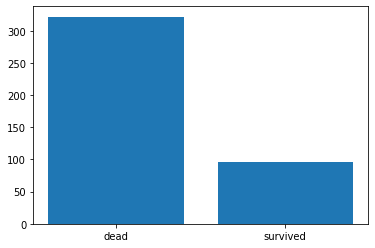

In [55]:
import matplotlib.pyplot as plt

# 予測生存者数のカウント
survived, dead = 0, 0
for _ in my_prediction:
    if _ == 0:
        dead += 1 
    else:
        survived += 1

# 描画
x = ["dead", "survived"]
y = [dead, survived]
plt.bar(x, y)

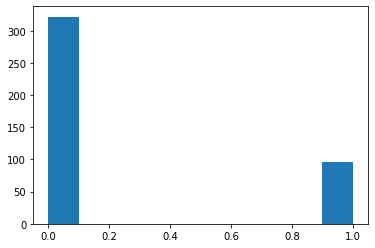

In [46]:
 # PassengerIdの取得
PassengerId = np.array(test["PassengerId"]).astype(int)

# IDと予測データのデータフレームを作成
my_solution = pd.DataFrame(my_prediction, PassengerId, columns = ["Survived"])

# csv書き出し
my_solution.to_csv("my_tree_one.csv", index_label = ["PassengerId"])